## Run Nearest Neighbor KDE on the data set

In [249]:
# 3rd party
import nnkcde
import matplotlib.pyplot as plt
from cdetools.cde_loss import cde_loss
from pathlib import Path
import pandas as pd
import numpy as np
from scipy.integrate import simps
from cdetools.hpd_coverage import hpd_coverage
from cdetools.cdf_coverage import cdf_coverage
from sklearn.preprocessing import StandardScaler
from utils_cde_diagnostics import plot_with_uniform_band

In [250]:
exp_root_dir = Path('/Users/msaragoc/Library/CloudStorage/OneDrive-NASA/Projects/exoplanet_transit_classification/experiments/multi_plnt_sys_probing')

train_df = pd.read_csv(exp_root_dir / 'train_set.csv')
val_df = pd.read_csv(exp_root_dir / 'val_set.csv')
test_df = pd.read_csv(exp_root_dir / 'test_set.csv')

### Filter single-planet examples

In [ ]:
def single_filter(dataset_df):
    """ Filter out single-planet examples from the data set.

    Args:
        dataset_df: pandas DataFrame, data set with multis and singles.

    Returns: DataFrame, same data set without singles.

    """
    planet_cnts_per_target = dataset_df['kepid'].value_counts()
    multis_targets = planet_cnts_per_target.loc[planet_cnts_per_target > 1].index
    return dataset_df.loc[dataset_df['kepid'].isin(multis_targets)]

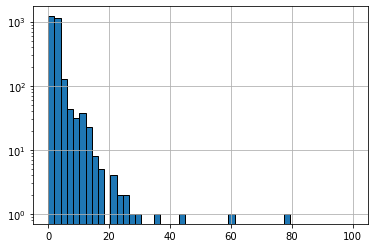

In [280]:
all_dataset_df = pd.concat([train_df, val_df, test_df], axis=0)

all_dataset_df['koi_prad'].hist(bins=np.linspace(0, 100), edgecolor='k')
plt.yscale('log')

### Define input and target variables for each data set

In [251]:
features_columns = [
    'koi_prad_i-1',
    'koi_incl_i-1',
    'koi_period_i-1',
    'koi_prad_i+1',
    'koi_incl_i+1',
    'koi_period_i+1',
    # 'radius',
    # 'mass',
    # 'feh',
    # 'teff'
]

target_columns = [
    'koi_period'
]

In [252]:
X_train = train_df[features_columns].to_numpy()  # Feature matrix
y_train = train_df[target_columns].to_numpy()  # Target variable

X_val = val_df[features_columns].to_numpy()  # Feature matrix
y_val = val_df[target_columns].to_numpy()  # Target variable

X_test = test_df[features_columns].to_numpy()  # Feature matrix
y_test = test_df[target_columns].to_numpy()  # Target variable

### Plot features

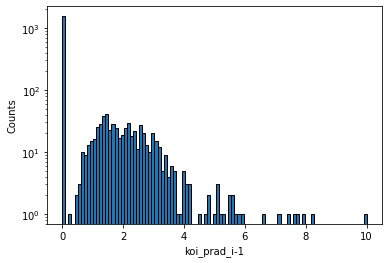

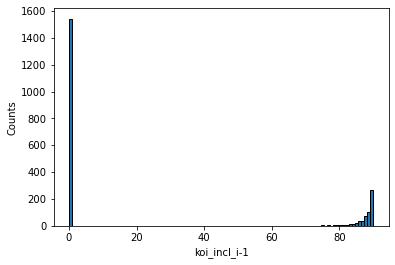

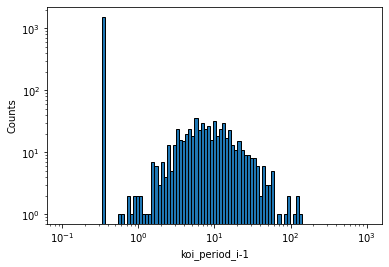

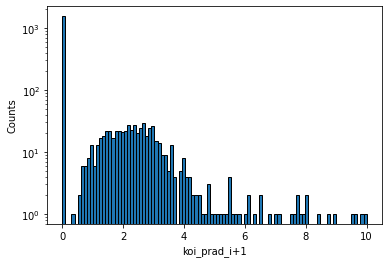

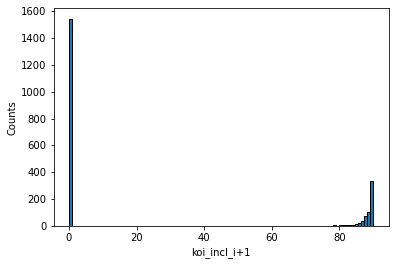

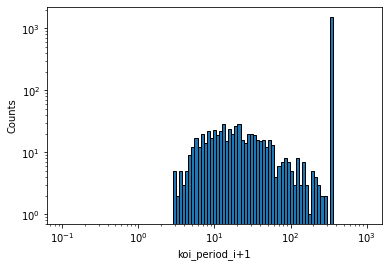

In [253]:
# plotting features of examples in the training set
plot_features = [
    'koi_prad_i-1',
    'koi_incl_i-1',
    'koi_period_i-1',
    'koi_prad_i+1',
    'koi_incl_i+1',
    'koi_period_i+1',
]

bins_prad = np.linspace(0, 10, 100, endpoint=True)
bins_incl = np.linspace(0, 90 , 100, endpoint=True)
bins_period = np.logspace(-1, 3, 100)

for feature in plot_features:

    f, ax = plt.subplots()

    if 'prad' in feature:
        ax.hist(train_df[feature], bins_prad, edgecolor='k')
        ax.set_yscale('log')

    elif 'incl' in feature:
        ax.hist(train_df[feature], bins_incl, edgecolor='k')

    elif 'period' in feature:
        ax.hist(train_df[feature], bins_period, edgecolor='k')
        ax.set_yscale('log')
        ax.set_xscale('log')

    ax.set_ylabel('Counts')
    ax.set_xlabel(feature)
    f.savefig(exp_root_dir / f'hist_{feature}.svg')


### Scale features

In [254]:
# standardize each feature independently using the mean and std estimates from the training set
std_scaler = StandardScaler()
std_scaler.fit(X_train)

X_train = std_scaler.transform(X_train)
X_val = std_scaler.transform(X_val)
X_test = std_scaler.transform(X_test)

### Define model

In [255]:
# k = 7  # number of training set neighbors; this can also be specified when predicting
model = nnkcde.NNKCDE(k=None)

### Fit model to training data

In [256]:
model.fit(X_train, y_train)  # basically it just stores the training set (lazy estimator)

### Hyperparameter optimization (grid search) using validation set

In [272]:
bw_vals = [0.1, 1, 2.5, 5, 10, 15, 20]  # bandwidth values to be tested (in period units)
k_vals = [1, 3, 5, 7, 10, 25, 50, 100]  # , 11, 20, 30, 50, 80, 100]  # number of neighbors to be considered

# create the CDE support, i.e. the grid over which we want the CDE to be predicted. Here we use the training data to inform the y_train minimum and maximum, and generate n_grid linearly separated values between the two.
n_grid = 4000  # number of points in the support grid between min and max period
y_grid = np.linspace(y_train.min(), y_train.max(), n_grid)

# log results into dictionary
results_cols = ['bandwidth', 'neighbors', 'Train_mean_cde_loss','Train_std_cde_loss', 'Val_mean_cde_loss', 'Val_std_cde_loss', 'Test_mean_cde_loss', 'Test_std_cde_loss']
results_search = {col: [] for col in results_cols}
for bw in bw_vals:
    for k in k_vals:

        results_search['bandwidth'].append(bw)
        results_search['neighbors'].append(k)

        # evaluate on multiple data sets
        for dataset, dataset_name in zip([(X_val, y_val), (X_train, y_train), (X_test, y_test)], ['Val', 'Train', 'Test']):
            cde_dataset_temp = model.predict(dataset[0], y_grid, k=k, bandwidth=bw)
            cde_loss_temp, std_loss_temp = cde_loss(cde_dataset_temp, y_grid, dataset[1])
            results_search[f'{dataset_name}_mean_cde_loss'].append(cde_loss_temp)
            results_search[f'{dataset_name}_std_cde_loss'].append(std_loss_temp)


        message_out = r'Bandwith: %.2f, Neighbors: %d, CDE loss: %4.4f +- %.4f' % (bw, k, results_search[f'Val_mean_cde_loss'], results_search[f'Val_std_cde_loss'])
        print(message_out)

# save results into a csv file
results_search_df = pd.DataFrame(results_search)
results_search_df.to_csv('hpo_results.csv', index=False)

# get set of hyperparameters with the lowest mean CDE loss on the validation set
best_combination = results_search_df.sort_values('Val_mean_cde_loss').iloc[0]
print('\nBest CDE loss in validation set (%4.4f +- %4.4f) is achieved using %d Neighbors and KDE bandwidth=%.2f' % (best_combination['Val_mean_cde_loss'], best_combination['Val_std_cde_loss'], best_combination['neighbors'], best_combination['bandwidth']))

# get estimates for the other sets (train and test) - don't use them for model selection!=
print(f'CDE loss for the training set is {best_combination["Train_mean_cde_loss"]} +- {best_combination["Train_std_cde_loss"]}')
print(f'CDE loss for the test set is {best_combination["Test_mean_cde_loss"]} +- {best_combination["Test_std_cde_loss"]}')

Bandwith: 0.10, Neighbors: 3, CDE loss: 0.86 \pm 0.03
Bandwith: 0.10, Neighbors: 5, CDE loss: 0.50 \pm 0.02
Bandwith: 0.10, Neighbors: 7, CDE loss: 0.33 \pm 0.02
Bandwith: 0.10, Neighbors: 10, CDE loss: 0.21 \pm 0.01
Bandwith: 0.10, Neighbors: 25, CDE loss: 0.06 \pm 0.01
Bandwith: 0.10, Neighbors: 50, CDE loss: 0.01 \pm 0.01
Bandwith: 0.10, Neighbors: 100, CDE loss: -0.02 \pm 0.01
Bandwith: 0.10, Neighbors: 500, CDE loss: -0.03 \pm 0.00
Bandwith: 1.00, Neighbors: 3, CDE loss: 0.00 \pm 0.01
Bandwith: 1.00, Neighbors: 5, CDE loss: -0.00 \pm 0.01
Bandwith: 1.00, Neighbors: 7, CDE loss: -0.03 \pm 0.01
Bandwith: 1.00, Neighbors: 10, CDE loss: -0.03 \pm 0.01
Bandwith: 1.00, Neighbors: 25, CDE loss: -0.04 \pm 0.00
Bandwith: 1.00, Neighbors: 50, CDE loss: -0.04 \pm 0.00
Bandwith: 1.00, Neighbors: 100, CDE loss: -0.04 \pm 0.00
Bandwith: 1.00, Neighbors: 500, CDE loss: -0.04 \pm 0.00
Bandwith: 2.50, Neighbors: 3, CDE loss: -0.03 \pm 0.00
Bandwith: 2.50, Neighbors: 5, CDE loss: -0.03 \pm 0.00
Ban

### Check closest k-neighbors

In [266]:
# query the test set examples
neighbors_X_test_dist, neighbors_X_test = model.tree.query(X_test, best_combination['neighbors'])
# query the training set examples
neighbors_X_train_dist, neighbors_X_train = model.tree.query(X_train, best_combination['neighbors'])

In [264]:
# choose example from the test set to check closest k-neighbors
# example_idx = test_df.loc[test_df['kepoi_name'] == 'K00904.05'].index[0]
# choose example from the training set to check closest k-neighbors
example_idx = train_df.loc[train_df['kepoi_name'] == 'K00701.05'].index[0]

idx_test_example = [example_idx]  # test examples to be analyzed

# for test set example
# pd.concat([test_df.loc[idx_test_example, ['kepid', 'kepoi_name', 'koi_period']].reset_index(drop=True), pd.DataFrame(std_scaler.inverse_transform(X_test[idx_test_example].reshape(1, -1)), columns=features_columns)], axis=1)
# for training set example
pd.concat([train_df.loc[idx_test_example, ['kepid', 'kepoi_name', 'koi_period']].reset_index(drop=True), pd.DataFrame(std_scaler.inverse_transform(X_train[idx_test_example].reshape(1, -1)), columns=features_columns)], axis=1)

,kepid,kepoi_name,koi_period,koi_prad_i-1,koi_incl_i-1,koi_period_i-1,koi_prad_i+1,koi_incl_i+1,koi_period_i+1
0,9002278,K00701.05,12.4418,1.33,89.97,5.714897,1.98,89.97,18.164073


In [268]:
# get closest k-neighbors to X_test examples

# pd.concat([train_df.loc[neighbors_X_test[idx_test_example].flatten(), ['kepid', 'kepoi_name', 'koi_period']].reset_index(drop=True), pd.DataFrame(neighbors_X_test_dist[idx_test_example].flatten(), columns=['distance']), pd.DataFrame(std_scaler.inverse_transform(X_train[neighbors_X_test[idx_test_example].flatten()]), columns=features_columns)], axis=1)
# get closest k-neighbors to X_train examples
pd.concat([train_df.loc[neighbors_X_train[idx_test_example].flatten(), ['kepid', 'kepoi_name', 'koi_period']].reset_index(drop=True), pd.DataFrame(neighbors_X_train_dist[idx_test_example].flatten(), columns=['distance']), pd.DataFrame(std_scaler.inverse_transform(X_train[neighbors_X_train[idx_test_example].flatten()]), columns=features_columns)], axis=1)

,kepid,kepoi_name,koi_period,distance,koi_prad_i-1,koi_incl_i-1,koi_period_i-1,koi_prad_i+1,koi_incl_i+1,koi_period_i+1
0,9002278,K00701.05,12.441800,0.000000,1.33,89.97,5.714897,1.98,89.97,18.164073
1,7747425,K01952.01,8.010393,0.149403,1.18,89.71,5.195594,2.04,88.98,27.666638
2,4852528,K00500.01,7.053527,0.159566,1.33,89.50,4.645382,2.16,89.96,9.521645
3,5689351,K00505.04,8.348192,0.175753,1.37,87.06,6.195460,2.24,87.99,13.767101
4,6021275,K00284.02,6.414913,0.190875,1.22,85.28,6.178174,1.93,85.52,18.010200
5,8013439,K02352.03,8.256286,0.221322,1.39,88.80,5.629044,1.58,88.80,13.391552
6,9590976,K00710.01,5.374933,0.230266,1.29,89.75,3.886889,1.84,86.96,8.586010


### Predict on test set

In [165]:
# %%time

# hyperparameters
bw = best_combination['bandwidth']  # kernel bandwidth
k = best_combination['neighbors']  # number of neighbors from the training set

# create the CDE support, i.e. the grid over which we want the CDE to be predicted. Here we use the training data to inform the y_train minimum and maximum, and generate n_grid linearly separated values between the two.
n_grid = 4000
y_grid = np.linspace(y_train.min(), y_train.max(), n_grid)

# predict on test set; each row is the prediction of the density function over the y_grid for the corresponding row in X_test
cde_test = model.predict(X_test, y_grid, k=k ,bandwidth=bw)

### Log results for the different data sets

In [ ]:
def logresults(data, neighbors, bandw, model):
    """ Logs results for a given data set, i.e., mean CDE loss, expected value, and number of planets in the system.

    Args:
        data: pandas DataFrame, data set
        neighbors: int, number of neighbors
        bandw: float, bandwidth value
        model: CKDE model

    Returns: pandas DataFrame, with added results to the data set.

    """

    df_CDE = data[['kepid',
                   'kepoi_name',
                   'koi_prad_i-1',
                   'koi_incl_i-1',
                   'koi_period_i-1',
                   'koi_prad_i+1',
                   'koi_incl_i+1',
                   'koi_period_i+1',
                   'koi_period',
                   'radius',
                   'mass',
                   'feh',
                   'teff']].copy()

    df_CDE['CDE_loss'] = np.nan
    df_CDE['Y_true'] = df_CDE['koi_period'] # np.nan
    df_CDE['N_planets_in_system'] = np.nan

    # now we must calculate expected val, CDE loss, Y_true, N_planets_in_system
    for index, row in df_CDE.iterrows():

        # calculating N planets in system
        df_CDE.loc[index, 'N_planets_in_system'] = (df_CDE['kepid'] == row["kepid"]).sum()

        # calculating CDE loss, we had to add .values to convert from a panda series and reshaped so that it matches the training set size
        X_data_csv = row[features_columns].values.reshape(1, -1)
        y_data_csv = row[target_columns].values.reshape(1, -1)

        cde_data_temp = model.predict(X_data_csv, y_grid, k=neighbors, bandwidth=bandw)
        cde_loss_temp, std_loss_temp = cde_loss(cde_data_temp, y_grid, y_data_csv)
        df_CDE.loc[index, 'CDE_loss'] = cde_loss_temp

        # calculating expected value
        expected_value = np.sum(np.multiply(cde_data_temp, y_grid)) / np.sum(cde_data_temp)
        df_CDE.loc[index, 'Expected_value'] = expected_value

    return df_CDE

In [ ]:
for dataset_name, dataset in zip(['train', 'val', 'test'], [train_df, val_df, test_df]):
    dataset_res = logresults(dataset, k, bw, model)
    dataset_res.to_csv(f'{dataset_name}_{k}_neighbors_{bw}_bandwidth.csv', index=False)

### The output CDEs are n_grid dimensional densities, stored in a numpy array. They are proper density, i.e. they integrate to ~1.

In [166]:
print(type(cde_test), cde_test.shape)
#  computing integral for density function estimate of example zero
den_integral = simps(cde_test[0, :], x=y_grid)
print('Integral of the first density integrates to: %.2f' % den_integral)

<class 'numpy.ndarray'> (257, 4000)
Integral of the first density integrates to: 0.93


### Visualize the conditional density estimates for test set examples

In [276]:
# plot directory
plot_save_dir = Path(exp_root_dir / 'cde_plots_new_bandwidth_low_max_k')
plot_save_dir.mkdir(exist_ok=True)

# choose KOIs that belong to multiplanetary systems (i.e., more than 3 KOIs since "fake" KOIs were added to all systems)
# idxs_examples_to_plot = test_df.loc[test_df['kepid'].isin((test_df['kepid'].value_counts() > 3).index)].index
# choose KOIs that belong to multiplanetary systems (i.e., more than 3 KOIs since "fake" KOIs were added to all systems) and with a KOI period larger than 20 days
# idxs_examples_to_plot = test_df.loc[((test_df['kepid'].isin((test_df['kepid'].value_counts() > 3).index)) & (test_df['koi_period'] > 20))].index
# choose KOIs that do not have fake neighbors
idxs_examples_to_plot = test_df.loc[((~test_df['kepoi_name_i-1'].str.contains('inner')) & (~test_df['kepoi_name_i+1'].str.contains('outer')))].index

num_to_plot = 100  # number of examples too sample from the set
sampled_idxs_examples_to_plot = np.random.choice(idxs_examples_to_plot, num_to_plot)

# fig = plt.figure(figsize=(30, 25))
# for jj, cde_predicted in enumerate(cde_test[:10,:]):
for sampled_idx in sampled_idxs_examples_to_plot:

    cde_predicted = cde_test[sampled_idx]
    cde_expected_value = (np.sum(np.multiply(cde_predicted, y_grid))) / np.sum(cde_predicted)

    # ax = fig.add_subplot(5, 2, jj + 1)
    f, ax = plt.subplots(figsize=(12, 6))
    ax.plot(y_grid, cde_predicted, label=r'$\hat{p}(Y| x_{\rm obs})$')
    ax.axvline(y_test[sampled_idx], color='red', label=r'$Y_{\rm obs}$')
    ax.axvline(cde_expected_value, color='orange', label=r'$Y_{\rm exp}$', zorder=2)
    ax.axvline(test_df.loc[sampled_idx, 'koi_period_i-1'], color='green', label=r'$Y_{\rm i-1}$', zorder=2)
    ax.axvline(test_df.loc[sampled_idx, 'koi_period_i+1'], color='yellow', label=r'$Y_{\rm i+1}$', zorder=2)
    # plot all other KOIs for the system
    for example_i, example in test_df.loc[((test_df['kepid'] == test_df.loc[sampled_idx, 'kepid']) & (test_df['kepoi_name'] != test_df.loc[sampled_idx, 'kepoi_name']))].iterrows():
        ax.axvline(example['koi_period'], color='k', linestyle='--', zorder=1, alpha=0.5)

    # ax.set_xticks(size=16)
    # ax.set_yticks(size=16)
    ax.set_xlabel(r'Planet Period (days)', size=20)
    ax.set_ylabel('CDE', size=20)
    ax.legend(loc='upper right', prop={'size': 18})
    ax.set_xscale('log')
    ax.set_title(f'KIC {test_df.loc[sampled_idx, "kepid"]} KOI {test_df.loc[sampled_idx, "kepoi_name"]}\nY_pred={y_grid[np.argmax(cde_predicted)]:.3f}, Y_obs={y_test[sampled_idx][0]:.3f}')
    # add table with features for this example
    ax.table(cellText=np.array([features_columns, test_df.loc[sampled_idx, features_columns].astype('str').to_list()]).T,
         loc='right',
         bbox=[1, 0, .5, 1]
         )
    plt.tight_layout()
    f.savefig(plot_save_dir / f'cde_koi_{test_df.loc[sampled_idx, "kepoi_name"]}.svg')
    plt.close()  # don't show plots in the Jupyte notebook
# plt.show()

### CDE diagnostics

In [137]:
# Computing the values
y_grid = np.linspace(y_train.min(), y_train.max(), n_grid)
pit_values = cdf_coverage(cde_test, y_grid, y_test)
hpd_values = hpd_coverage(cde_test, y_grid, y_test)

In [139]:
# Computing the values
y_grid = np.linspace(y_train.min(), y_train.max(), n_grid)
pit_values = cdf_coverage(cde_test, y_grid, y_test)
hpd_values = hpd_coverage(cde_test, y_grid, y_test)

### Computing the number of values per each bin in the histogram under uniformity assumptions. We look at the 99% CI.

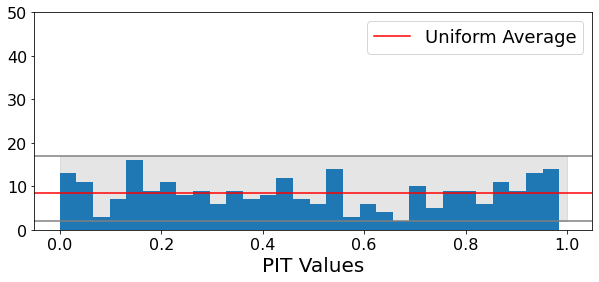

In [140]:
fig_pit = plot_with_uniform_band(values=pit_values, ci_level=0.99, x_label='PIT Values', n_bins=30)
fig_pit

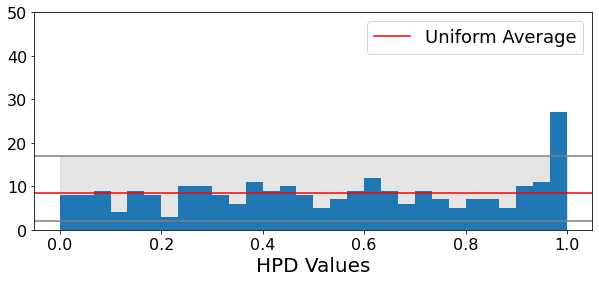

In [141]:
fig_hpd = plot_with_uniform_band(values=hpd_values, ci_level=0.99, x_label='HPD Values', n_bins=30)
fig_hpd